<a href="https://colab.research.google.com/github/lacuentadesilvana/DataSciencieOne/blob/main/ProyectoParteIII%2BMelitsko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

El objetivo de este proyecto es caracterizar la situación laboral de la población urbana argentina teniendo en cuenta variables demográficas y económicas como sexo, edad, estado civil, nivel educativo, región y actividad económica.

En la primera entrega caractericé a la población mediante estadísticas descriptivas agregadas a nivel nacional y por jurisdicción. En esta segunda entrega me concentro en explorar los determinantes de la situación laboral y el ingreso de la población ocupada a través de distintos modelos.

En primera instancia voy a considerar modelos de aprendizaje supervisado de clasificación para predecir la condición de "ocupado". En segunda instancia voy a evaluar modelos de aprendizaje supervisado de regresión para evaluar los determinantes de los ingresos que obtienen de su ocupación principal las personas ocupadas. En ambos casos implementaré algoritmos de feature selection para establecer los atributos más relevantes a ser considerados en los distintos modelos.

Para desarrollar este proyecto voy a utilizar la base individual de la Encuesta Permanente de Hogares (EPH) que lleva adelante el Indec con periodicidad trimestral, cuyo dataset se encuentra disponible en: https://www.indec.gob.ar/indec/web/Institucional-Indec-BasesDeDatos

Algunas aclaraciones importantes respecto al dataset:

1) En la entrega final utilizo el dataset correspondiente al último período que estaba disponible al momento de la entrega preliminar (tercer trimestre de 2024).

2) En el dataset los datos faltantes por no respuesta se encuentran codificados numéricamente (para mayor detalle, ver Anexo I en: https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_registro_3T2024.pdf).

3) El tamaño de la muestra es de 47564. Sin embargo hay un conjunto de variables relacionadas con la ocupación (ingresos, horas trabajadas, etc.) que solo son aplicables a la población ocupada o en algunos casos desocupada con ocupación anterior. Si excluimos a la población que no tiene o no tuvo ocupación (principalmente niños y jóvenes) la muestra se reduce a 21.031. Mientras que en los modelos de regresión usamos solo datos de población ocupada, en los modelos de clasificación tenemos en cuenta también a la población desocupada e inactiva, si bien restringimos el rango de edad, ya que el interés principal de este proyecto es estudiar la situación laboral de la población adulta (25-65 años).

# 1 - Importar librerías y cargar datos

In [ ]:
# Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargamos datos
filename = '/content/drive/My Drive/DATOS-EPH/usu_individual_T324.txt'

var_list_individual = [ "REGION", "AGLOMERADO", "PONDERA", "CH03", "CH04",
                  "CH06", "CH07", "NIVEL_ED", "ESTADO", "CAT_OCUP", "P21" ,
                        "PP3E_TOT", "PP03D", "PP07H", "PP04D_COD", "PP04B_COD" ]

df = pd.read_csv(filename, delimiter = ";", usecols = var_list_individual)

# 2 - Pre procesamiento

## 2.1 Re nombrar variables

In [ ]:
# Nombres en minúscula
df.columns = df.columns.str.lower()

# Reemplazar nombre de variables:
dict_nombre_var = {"ch03":"parentesco_jefe",
                   "ch04":"sexo", "ch06":"edad", "ch07": "estado_civil",
                   "p21":"ingreso",
                   "pp03d": "n_ocupaciones", "pp3e_tot": "horas_semana",
                   "pp07h": "empleo_formal", "pp04d_cod": "codigo_ocupacion", "pp04b_cod": "codigo_actividad"}

df.rename(columns = dict_nombre_var, inplace = True)

print(df.info())
print(df.sample(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47564 entries, 0 to 47563
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   region            47564 non-null  int64  
 1   aglomerado        47564 non-null  int64  
 2   pondera           47564 non-null  int64  
 3   parentesco_jefe   47564 non-null  int64  
 4   sexo              47564 non-null  int64  
 5   edad              47564 non-null  int64  
 6   estado_civil      47564 non-null  int64  
 7   nivel_ed          47564 non-null  int64  
 8   estado            47564 non-null  int64  
 9   cat_ocup          47564 non-null  int64  
 10  n_ocupaciones     21031 non-null  float64
 11  horas_semana      21031 non-null  float64
 12  codigo_actividad  21031 non-null  float64
 13  codigo_ocupacion  21031 non-null  float64
 14  empleo_formal     21031 non-null  float64
 15  ingreso           47564 non-null  int64  
dtypes: float64(5), int64(11)
memory usage: 5

Observamos que todas las variables están codificadas numéricamente. La codificación se encuentra en:

https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_registro_3T2024.pdf

Además, las variables que refieren a la ocupación principal (ingreso, código de ocupación, códico de actividad, horas trabajadas última semana) solo están disponibles para la población ocupada (estado = 1). Eso explica la gran proporción de NaN.

## 2.2 Re codificar variables categóricas

In [ ]:
# Variable educación: el nivel 7 es "sin instrucción". Para que estén ordenados, lo convierto de 7 a 0.
Indice = df.nivel_ed == 7
df.loc[Indice, "nivel_ed"] = 0

In [ ]:
# Decodificar variables categóricas a partir de diccionarios
# Primero defino los diccionarios (documentación INDEC)
aglomerado_d = {2 : "Gran La Plata",
3 : "Bahía Blanca - Cerri",
4 : "Gran Rosario",
5 : "Gran Santa Fé",
6 : "Gran Paraná",
7 : "Posadas",
8 : "Gran Resistencia",
9 : "Comodoro Rivadavia - Rada Tilly",
10 : "Gran Mendoza",
12 : "Corrientes",
13 : "Gran Córdoba",
14 : "Concordia",
15 : "Formosa",
17 : "Neuquén – Plottier",
18 : "Santiago del Estero - La Banda",
19 : "Jujuy - Palpalá",
20 : "Río Gallegos",
22 : "Gran Catamarca",
23 : "Gran Salta",
25 : "La Rioja",
26 : "Gran San Luis",
27 : "Gran San Juan",
29 : "Gran Tucumán - Tafí Viejo",
30 : "Santa Rosa – Toay",
31 : "Ushuaia - Río Grande",
32 : "Ciudad Autónoma de Buenos Aires",
33 : "Partidos del GBA",
34 : "Mar del Plata",
36 : "Río Cuarto",
38 : "San Nicolás – Villa Constitución",
91 : "Rawson – Trelew",
93 : "Viedma – Carmen de Patagones"
}


region_d = {1 : "Gran Buenos Aires",
            40 : "Noroeste",
            41 : "Noreste",
            42 : "Cuyo",
            43 : "Pampeana",
            44 : "Patagonia"}


parentesco_jefe_d = {1 : "Jefe",
2 : "Cónyuge o pareja",
3 : "Hijo o hijastro",
4 : "Yerno o nuera",
5 : "Nieto",
6 : "Madre o padre",
7 : "Suegro",
8 : "Hermano",
9 : "Otros familiares",
10 : "No familiares"
}

sexo_d = {1: "Varón", 2: "Mujer"}

estado_d = {0: "Entrevista no realizada", 1: "Ocupado", 2: "Desocupado", 3: "Inactivo", 4: "Menor de 10"}

cat_ocup_d = {1: "Patrón", 2: "Cuenta propia", 3: "Empleado", 4: "Trabajador familiar sin remuneración", 9: "NS/NR"}

empleo_formal_d = {1: "Sí", 2:"No"}

estado_civil_d = {1: "unido", 2: "casado", 3: "separado", 4: "viudo", 5: "soltero", 9: "sin datos"}

# Reemplazo

df["region"] = df["region"].replace(region_d)

df["aglomerado"] = df["aglomerado"].replace(aglomerado_d)

df["parentesco_jefe"] = df["parentesco_jefe"].replace(parentesco_jefe_d)

df["sexo"] = df["sexo"].replace(sexo_d)

df["estado"] = df["estado"].replace(estado_d)

df["cat_ocup"] = df["cat_ocup"].replace(cat_ocup_d)

df["empleo_formal"] = df["empleo_formal"].replace(empleo_formal_d)

df["estado_civil"] = df["estado_civil"].replace(estado_civil_d)

In [ ]:
# Convierto la variable código de actividad económica en string para después transformar en variables dicotómicas
df["codigo_actividad"] = df["codigo_actividad"].astype(str).values


In [ ]:
# Construyo la variable "horas mensuales" a partir de los datos de horas semanales
df["horas_mes"] = df["horas_semana"]/7*30

In [ ]:
print(df.info())
print(" ")
print(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47564 entries, 0 to 47563
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   region            47564 non-null  object 
 1   aglomerado        47564 non-null  object 
 2   pondera           47564 non-null  int64  
 3   parentesco_jefe   47564 non-null  object 
 4   sexo              47564 non-null  object 
 5   edad              47564 non-null  int64  
 6   estado_civil      47564 non-null  object 
 7   nivel_ed          47564 non-null  int64  
 8   estado            47564 non-null  object 
 9   cat_ocup          47564 non-null  object 
 10  n_ocupaciones     21031 non-null  float64
 11  horas_semana      21031 non-null  float64
 12  codigo_actividad  47564 non-null  object 
 13  codigo_ocupacion  21031 non-null  float64
 14  empleo_formal     21031 non-null  object 
 15  ingreso           47564 non-null  int64  
 16  horas_mes         21031 non-null  float6

Observamos que hay un número considerable de personas no empleadas dentro de las cuales se encuentran niños, adolescentes y adultos mayores. Seguidamente se procederá a eliminar del dataframe a ambos grupos para concentrarnos en el comportamiento de las personas adultas.

## 2.3 Eliminar observaciones

In [ ]:
# Selecciono población adulta descartando niños, estudiantes universitarios y jubilados.
# Descarto también casos de entrevistas individuales no realizadas.
Indice = (df["edad"] >= 25) & (df["edad"] < 65) & (df["estado"] != "Entrevista no realizada")
df = df.loc[Indice]

print(df.info())
print(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
Index: 24057 entries, 0 to 47562
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   region            24057 non-null  object 
 1   aglomerado        24057 non-null  object 
 2   pondera           24057 non-null  int64  
 3   parentesco_jefe   24057 non-null  object 
 4   sexo              24057 non-null  object 
 5   edad              24057 non-null  int64  
 6   estado_civil      24057 non-null  object 
 7   nivel_ed          24057 non-null  int64  
 8   estado            24057 non-null  object 
 9   cat_ocup          24057 non-null  object 
 10  n_ocupaciones     18014 non-null  float64
 11  horas_semana      18014 non-null  float64
 12  codigo_actividad  24057 non-null  object 
 13  codigo_ocupacion  18014 non-null  float64
 14  empleo_formal     18014 non-null  object 
 15  ingreso           24057 non-null  int64  
 16  horas_mes         18014 non-null  float64
dty

Observamos que el tamaño de la muestra se redujo a 24.057 registros frente a los 47.564 de la muestra original.

Una vez eliminados adultos mayores, niños y adolescentes, la población ocupada constituye una proporción mayoritaria de la muestra total.

## 2.4 Codificar variables dicotómicas

Utilizaremos la librería OneHotEncoder para transformar variables categóricas en valores dicotómicos para introducirlas en los modelos de aprendizaje.

Los modelos de clasificación y regresión utilizan diferentes conjuntos de variables, de manera que creamos dos dataframes separados.

In [ ]:
# Creamos un dataframe para modelos de clasificacion (df_clasificacion)

variables_modelos_clasificacion = ["sexo", "region",  "parentesco_jefe", "estado_civil"]
cat_encoder = OneHotEncoder()
# dataframe vacío
df_clasificacion = pd.DataFrame()

# codifico y agrego variables al dataframe
for n in variables_modelos_clasificacion:
  data_cat_1hot = cat_encoder.fit_transform(df[[n]])
  encoded_df_n = pd.DataFrame(data_cat_1hot.toarray(), columns=cat_encoder.get_feature_names_out())
  df_clasificacion = pd.concat([df_clasificacion, encoded_df_n], axis=1)

# Asigno índice del dataset original.
# El nuevo dataset genera indices de valores consecutivos mientras que en el original
# los índices no eran consecutivos debido a la eliminación de observaciones

df_clasificacion.index = df.index

In [ ]:
print(df.info())
print(df_clasificacion.info())

<class 'pandas.core.frame.DataFrame'>
Index: 24057 entries, 0 to 47562
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   region            24057 non-null  object 
 1   aglomerado        24057 non-null  object 
 2   pondera           24057 non-null  int64  
 3   parentesco_jefe   24057 non-null  object 
 4   sexo              24057 non-null  object 
 5   edad              24057 non-null  int64  
 6   estado_civil      24057 non-null  object 
 7   nivel_ed          24057 non-null  int64  
 8   estado            24057 non-null  object 
 9   cat_ocup          24057 non-null  object 
 10  n_ocupaciones     18014 non-null  float64
 11  horas_semana      18014 non-null  float64
 12  codigo_actividad  24057 non-null  object 
 13  codigo_ocupacion  18014 non-null  float64
 14  empleo_formal     18014 non-null  object 
 15  ingreso           24057 non-null  int64  
 16  horas_mes         18014 non-null  float64
dty

In [ ]:
print(df_clasificacion.sample(10))

       sexo_Mujer  sexo_Varón  region_Cuyo  region_Gran Buenos Aires  \
26011         0.0         1.0          0.0                       1.0   
1500          0.0         1.0          0.0                       1.0   
37213         1.0         0.0          0.0                       0.0   
9535          0.0         1.0          0.0                       0.0   
31734         0.0         1.0          0.0                       0.0   
9591          1.0         0.0          0.0                       0.0   
21206         1.0         0.0          0.0                       0.0   
12526         0.0         1.0          0.0                       0.0   
6881          0.0         1.0          0.0                       0.0   
14898         0.0         1.0          0.0                       1.0   

       region_Noreste  region_Noroeste  region_Pampeana  region_Patagonia  \
26011             0.0              0.0              0.0               0.0   
1500              0.0              0.0              0

In [ ]:
# Creamos un dataframe de valores dicotómicos con las variables seleccionadas para modelos de regresion

variables_modelos_regresion = ["sexo", "region",  "parentesco_jefe", "estado_civil", "codigo_actividad"]
cat_encoder = OneHotEncoder()
df_regresion = pd.DataFrame()

for n in variables_modelos_regresion:
  data_cat_1hot = cat_encoder.fit_transform(df[[n]])
  encoded_df_n = pd.DataFrame(data_cat_1hot.toarray(), columns=cat_encoder.get_feature_names_out())
  df_regresion = pd.concat([df_regresion, encoded_df_n], axis=1)

df_regresion.index = df.index

In [ ]:
print(df_regresion.info())

<class 'pandas.core.frame.DataFrame'>
Index: 24057 entries, 0 to 47562
Columns: 164 entries, sexo_Mujer to codigo_actividad_nan
dtypes: float64(164)
memory usage: 30.3 MB
None


# 3 - Modelos de Clasificación

## 3.1 Preparación de los datos

In [ ]:
# Variables explicativas (x)
# Incluyo en la matriz x todas las variables cualitativas dicotómicas (sexo, región, estado civil, parentesco con el jefe de hogar)
x = df_clasificacion
# Agrego variables cuantitativas (educación y edad) del dataframe original
x["nivel_ed"] = df["nivel_ed"].values
x["edad"] = df["edad"].values
x.info()


<class 'pandas.core.frame.DataFrame'>
Index: 24057 entries, 0 to 47562
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   sexo_Mujer                        24057 non-null  float64
 1   sexo_Varón                        24057 non-null  float64
 2   region_Cuyo                       24057 non-null  float64
 3   region_Gran Buenos Aires          24057 non-null  float64
 4   region_Noreste                    24057 non-null  float64
 5   region_Noroeste                   24057 non-null  float64
 6   region_Pampeana                   24057 non-null  float64
 7   region_Patagonia                  24057 non-null  float64
 8   parentesco_jefe_Cónyuge o pareja  24057 non-null  float64
 9   parentesco_jefe_Hermano           24057 non-null  float64
 10  parentesco_jefe_Hijo o hijastro   24057 non-null  float64
 11  parentesco_jefe_Jefe              24057 non-null  float64
 12  parentesc

In [ ]:
# Variable target o variable a explicar (y)
# Quiero explicar o predecir qué personas están "Ocupadas"
y = df.loc[: , ["estado"]].values == "Ocupado"
y = y.ravel()
print(f"Tamaño del vector y: {y.size}")


Tamaño del vector y: 24057


## 3.2 Feature Selection

In [ ]:
# Utilizo un método de feature selection de clasificación Random Forest
from sklearn.ensemble import RandomForestClassifier
modelo = RandomForestClassifier(random_state = 0)
modelo.fit(x, y)
importancia = modelo.feature_importances_

# Ordeno la importancia de cada atributo por orden descendiente
indices_ordenados = importancia.argsort()[::-1]

# Selecciono los primeros 5 atributos
k = 5
atributos_seleccionados = x.columns[indices_ordenados[:k]]
importancia_atributos_seleccionados = importancia[indices_ordenados[:k]]

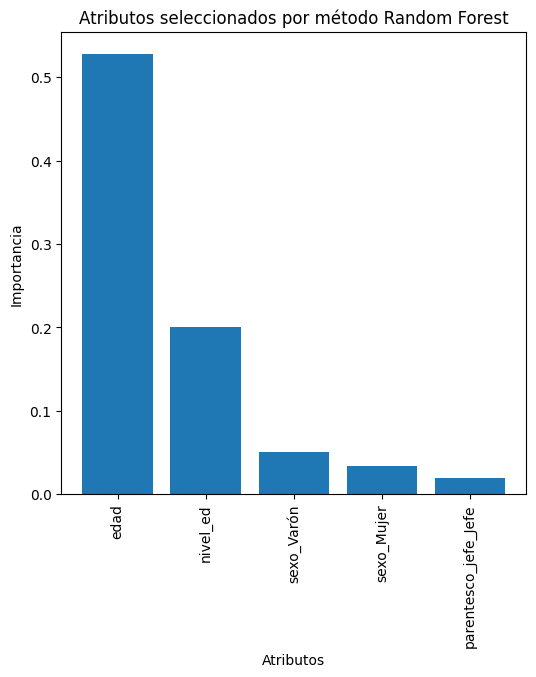

Atributos Seleccionados:
Index(['edad', 'nivel_ed', 'sexo_Varón', 'sexo_Mujer', 'parentesco_jefe_Jefe'], dtype='object')


In [ ]:
# Grafico los atributos principales
plt.figure(figsize=(6, 6))
plt.bar(range(len(importancia_atributos_seleccionados)), importancia_atributos_seleccionados, tick_label=atributos_seleccionados)
plt.xticks(rotation=90)
plt.xlabel('Atributos')
plt.ylabel('Importancia')
plt.title('Atributos seleccionados por método Random Forest')
plt.show()

print("Atributos Seleccionados:")
print(atributos_seleccionados)

In [ ]:
# Creo una matriz de datos reducida para usar en el modelo de clasificacion
x_reducida = pd.DataFrame()
for k in atributos_seleccionados:
  x_reducida[k] = x[k]

print(x.info())
print(" ")
print(x_reducida.info())

<class 'pandas.core.frame.DataFrame'>
Index: 24057 entries, 0 to 47562
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   sexo_Mujer                        24057 non-null  float64
 1   sexo_Varón                        24057 non-null  float64
 2   region_Cuyo                       24057 non-null  float64
 3   region_Gran Buenos Aires          24057 non-null  float64
 4   region_Noreste                    24057 non-null  float64
 5   region_Noroeste                   24057 non-null  float64
 6   region_Pampeana                   24057 non-null  float64
 7   region_Patagonia                  24057 non-null  float64
 8   parentesco_jefe_Cónyuge o pareja  24057 non-null  float64
 9   parentesco_jefe_Hermano           24057 non-null  float64
 10  parentesco_jefe_Hijo o hijastro   24057 non-null  float64
 11  parentesco_jefe_Jefe              24057 non-null  float64
 12  parentesc

## 3.3 Modelo de regresión **logística**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Paso 1: separo datos
x_train, x_test, y_train, y_test = train_test_split(x_reducida,y,test_size = 0.2, random_state = 42)

# Paso 2: estandarizo datos
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

# Paso 3: regresion logística
log_reg = LogisticRegression(random_state=0)
log_reg.fit(x_train, y_train)
y_pred = log_reg.predict(x_test)

# Paso 4: analizo desempeño
precision_logistica = precision_score(y_test, y_pred)
recall_logistica = recall_score(y_test, y_pred)
f1_score_logistica = f1_score(y_test, y_pred)

print(f"confusion matrix: {confusion_matrix(y_test, y_pred)}")
print(f"precision score: {precision_logistica}")
print(f"recall score: {recall_logistica}")
print(f"f1 score: {f1_score_logistica}")


confusion matrix: [[ 228 1009]
 [ 159 3416]]
precision score: 0.7719774011299435
recall score: 0.9555244755244755
f1 score: 0.854


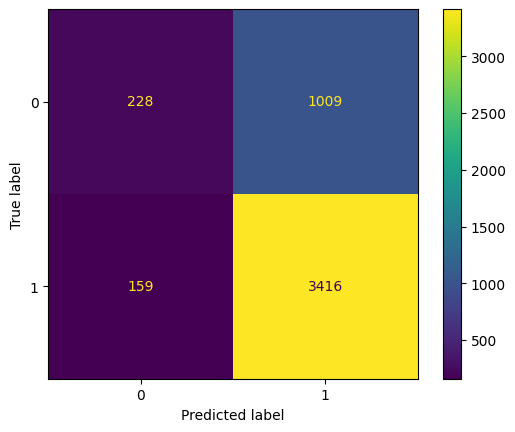

In [ ]:
#Ploteamos matriz de confusion
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()

Observamos que el número de personas ocupadas que son erróneamente etiquetadas como no ocupadas es relativamente chico (159) pero el número de personas no ocupadas erróneamente etiquetadas como ocupadas es bastante importante (1009). Esto se ve reflejado en un score de recall bastante alto (0.95) y un score de precisión no tan bueno (0.77).

## 3.4 Modelo **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

x_train, x_test, y_train, y_test = train_test_split(x_reducida, y, test_size=0.2, random_state=0)

# n_neighbors }: cantidad d epuntos vecinos
knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=1)

# entrenamos
knn.fit(x_train, y_train)

# hacemos predicciones
y_pred = knn.predict(x_test)

# Paso 4: analizo desempeño
precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)
f1_score_knn = f1_score(y_test, y_pred)

print(f"confusion matrix: {confusion_matrix(y_test, y_pred)}")
print(f"precision score: {precision_knn}")
print(f"recall score: {recall_knn}")
print(f"f1 score: {f1_score_knn}")


confusion matrix: [[ 412  803]
 [ 405 3192]]
precision score: 0.7989987484355444
recall score: 0.8874061718098415
f1 score: 0.8408851422550052


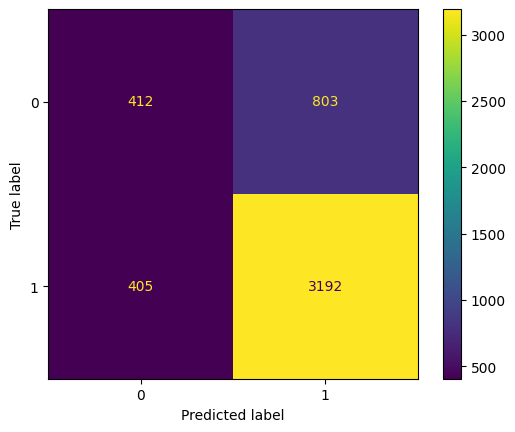

In [ ]:
#Ploteamos matriz de confusion
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()

Respecto al modelo anterior, aumenta el número de personas ocupadas que son erróneamente etiquetadas (405) pero se reduce el número de personas no ocupadas erróneamente etiquetadas como ocupadas (803). Esto se ve reflejado en un score de recall más bajo (0.89) y un score de precisión más alto (0.80).

## 3.5 **Conclusiones**

In [ ]:
print('------------------------------ RECALL SCORE-------------------------------------------')
print('% de aciertos Regresión Logística Recall:', recall_logistica)
print('% de aciertos KNN Recall:',recall_knn)
print('--------------------------------------------------------------------------------------')
print('------------------------------ PRECISION SCORE----------------------------------------')
print('% de aciertos Regresión Logística Precisión:', precision_logistica)
print('% de aciertos KNN Precisión:', precision_knn)
print('--------------------------------------------------------------------------------------')
print('------------------------------ F1 SCORE-----------------------------------------------')
print('% de aciertos Regresión Logística F1 Score:', f1_score_logistica)
print('% de aciertos KNN F1 Score:',f1_score_knn)

print('--------------------------------------------------------------------------------------')


------------------------------ RECALL SCORE-------------------------------------------
% de aciertos Regresión Logística Recall: 0.9555244755244755
% de aciertos KNN Recall: 0.8874061718098415
--------------------------------------------------------------------------------------
------------------------------ PRECISION SCORE----------------------------------------
% de aciertos Regresión Logística Precisión: 0.7719774011299435
% de aciertos KNN Precisión: 0.7989987484355444
--------------------------------------------------------------------------------------
------------------------------ F1 SCORE-----------------------------------------------
% de aciertos Regresión Logística F1 Score: 0.854
% de aciertos KNN F1 Score: 0.8408851422550052
--------------------------------------------------------------------------------------


A nivel global, según el criterio F1 score, no hay grandes diferencias entre ambos modelos, aunque el de regresión logística se presenta ligeramente superior. La elección de un modelo u otro dependerá de los costos relativos de clasificar erróneamente a un ocupado como desocupado y viceversa.

El modelo de regresión logística es el adecuado si la prioridad es clasificar correctamente a la mayor parte de los Ocupados (esto es, que la proporción de Ocupados etiquetados erroneamente como Desocupados o Inactivos sea lo más baja posible). Esto surge del mayor Recall Score del modelo de regresión logística.

En cambio, el modelo KNN es el adecuado si se prioriza la Precisión (no etiquetar como Ocupada a una persona Desocupada o Inactiva). Esto surge del mayor Precision Score del modelo KNN.



# 4 - Modelos de Regresión

## 4.1 Preparación de los datos

In [ ]:
# Variables explicativas (x)
x = df_regresion

# Agrego variables cuantitativas (educación, horas trabajadas, edad)
x["nivel_ed"] = df["nivel_ed"]
x["edad"] = df["edad"]
x["horas_mes"] = df["horas_mes"]


In [ ]:
# Creo índice para filtrar datos fatantes y outliers
# Criterios:
# personas ocupadas (estado = 1)
# horas trabajadas positivas y menores a 360 por mes;
# ingresos positivos (las observaciones sin información de ingreso están codificadas como -9) y menores a 10.000.000 por mes

Indice = (df["estado"]=="Ocupado") & (df["horas_mes"] >0 ) & (df["horas_mes"]<360 ) & (df["ingreso"]>0) & (df["ingreso"]<10000000)


In [ ]:
# Eliminar datos faltantes y outliers
x = x.loc[Indice]


In [ ]:
# Variable a explicar u objetivo (y)
# Quiero explicar o predecir el nivel de ingresos
y = df.loc[Indice , ["ingreso"]]


Número de observaciones: 13825
Ingreso mensual promedio en pesos: [557308]


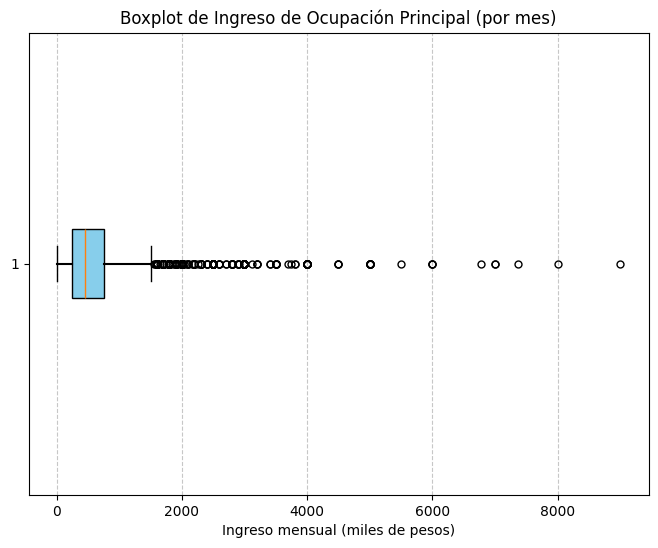

In [ ]:
# Analizamos algunas características de la variable objetivo

pd.options.display.float_format = '{:.1f}'.format

print(f"Número de observaciones: {y.size}")
y_promedio = sum(y.values)/y.values.size
print(f"Ingreso mensual promedio en pesos: {y_promedio.round(0).astype(int)}")

# Crear el Boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(y/1000, vert=False, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='black'),
            whiskerprops=dict(color='black', linewidth=1.5),
            flierprops=dict(marker='o', color='red', markersize=5))

# Añadir etiquetas y título
plt.xlabel('Ingreso mensual (miles de pesos)')
plt.title('Boxplot de Ingreso de Ocupación Principal (por mes)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.ticklabel_format(axis = "x", style="plain")


Observamos que el total de observaciones se redujo a 13.825. El número de columnas es de 167 debido al gran número de variables dicotómicas indicando clasificación de la actividad económica.

## 4.2 Feature Selection

In [ ]:
# Utilizo un modelo de regresión Random Forest
from sklearn.ensemble import RandomForestRegressor
modelo = RandomForestRegressor(random_state = 0)
modelo.fit(x, y)
importancia = modelo.feature_importances_

# Ordeno la importancia de cada atributo por orden descendiente
indices_ordenados = importancia.argsort()[::-1]

# Selecciono los primeros 10 atributos
k = 10
atributos_seleccionados = x.columns[indices_ordenados[:k]]
importancia_atributos_seleccionados = importancia[indices_ordenados[:k]]

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


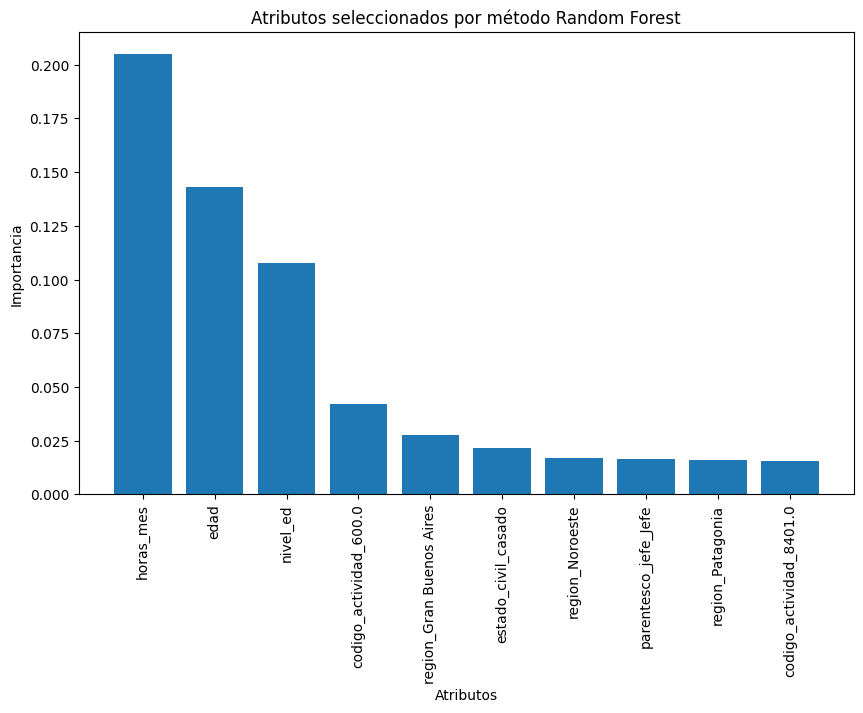

Atributos Seleccionados:
Index(['horas_mes', 'edad', 'nivel_ed', 'codigo_actividad_600.0',
       'region_Gran Buenos Aires', 'estado_civil_casado', 'region_Noroeste',
       'parentesco_jefe_Jefe', 'region_Patagonia', 'codigo_actividad_8401.0'],
      dtype='object')


In [ ]:
# Graficar los atributos principales
plt.figure(figsize=(10, 6))
plt.bar(range(len(importancia_atributos_seleccionados)), importancia_atributos_seleccionados, tick_label=atributos_seleccionados)
plt.xticks(rotation=90)
plt.xlabel('Atributos')
plt.ylabel('Importancia')
plt.title('Atributos seleccionados por método Random Forest')
plt.show()

print("Atributos Seleccionados:")
print(atributos_seleccionados)

Nota:

-actividad económica 0600 = Extracción de petróleo crudo y gas natural

-actividad económica 8401 = Servicios de la administración pública y prestación pública de servicios a la comunidad

In [ ]:
x_reducida = pd.DataFrame()
for k in atributos_seleccionados:
  x_reducida[k] = x[k]

print(x.info())
print(x_reducida.info())

<class 'pandas.core.frame.DataFrame'>
Index: 13825 entries, 6 to 47560
Columns: 167 entries, sexo_Mujer to horas_mes
dtypes: float64(165), int64(2)
memory usage: 17.7 MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 13825 entries, 6 to 47560
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   horas_mes                 13825 non-null  float64
 1   edad                      13825 non-null  int64  
 2   nivel_ed                  13825 non-null  int64  
 3   codigo_actividad_600.0    13825 non-null  float64
 4   region_Gran Buenos Aires  13825 non-null  float64
 5   estado_civil_casado       13825 non-null  float64
 6   region_Noroeste           13825 non-null  float64
 7   parentesco_jefe_Jefe      13825 non-null  float64
 8   region_Patagonia          13825 non-null  float64
 9   codigo_actividad_8401.0   13825 non-null  float64
dtypes: float64(8), int64(2)
memory usage: 1.2 MB
None


## 4.3 Modelo de regresión **simple**

Evaluamos un modelo de regresión simple incluyendo la variable de mayor improtancia según el modelo de random forest utilizado para seleccionar atributos (horas trabajadas)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, max_error, mean_absolute_error, r2_score

# Seleccionar la variable de entrada x (horas trabajadas)

x = x_reducida.loc[: , ["horas_mes"]].values.reshape(-1,1)
print(x.shape)
print(y.shape)

(13825, 1)
(13825, 1)


In [ ]:
# Paso 1: Separo datos
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 42)

# Paso 2: Modelo Regresion Lineal
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

# Paso 3: Predecir el modelo en los datos de testing
y_pred = lin_reg.predict(x_test)
print(y_pred.shape, y_test.shape, x_test.shape)

# Predicciones
print(f"Valores de x: {x_test[:4]}" )
print(f"Predicciones: {y_pred[:4]}  ---  Valores reales: {y_test[:4]}")



(2765, 1) (2765, 1) (2765, 1)
Valores de x: [[ 85.71428571]
 [ 55.71428571]
 [150.        ]
 [205.71428571]]
Predicciones: [[385424.52097372]
 [310155.58729773]
 [546715.09313656]
 [686500.25567769]]  ---  Valores reales:        ingreso
17111   600000
19232    20000
16763   300000
19490   400000


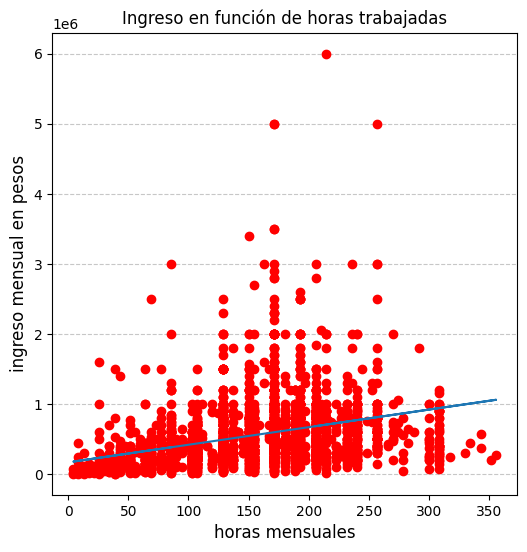

In [ ]:
# Graficar
plt.figure(figsize=(6,6))
plt.title('Ingreso en función de horas trabajadas')
plt.xlabel('horas mensuales', fontsize=12)
plt.ylabel('ingreso mensual en pesos', fontsize=12)

# Agregar cuadrícula horizontal -- alpha transparencia
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.plot(x_test,y_test,'ro')
plt.plot(x_test,y_pred)
plt.show()

In [ ]:
# Calcular métricas de desempeño

# 1-Error absoluto máximo
EAMAX_reg_simple = max_error(y_test, y_pred)
# 2-Error absoluto medio
EAMED_reg_simple = mean_absolute_error(y_test, y_pred)
# 3-Error cuadratico medio (MSE)
MSE_reg_simple = mean_squared_error(y_test, y_pred)
# 4-RMSE (raiz cuadrada del MSE)
RMSE_reg_simple = np.sqrt(mean_squared_error(y_test, y_pred))
# 5-Coeficiente de determinación (R2)
r2_reg_simple = lin_reg.score(x_test, y_test)

print(f"Error absoluto máximo: {EAMAX_reg_simple}")
print(f"Error absoluto medio: {EAMED_reg_simple}")
print(f"Error cuadratico medio (MSE): {MSE_reg_simple}")
print(f"Raíz cuadrada error cuadrático medio (RMSE): {RMSE_reg_simple}")
print(f"Coeficiente de determinación: {r2_reg_simple}")


Error absoluto máximo: 5291994.334700597
Error absoluto medio: 292339.98219128937
Error cuadratico medio (MSE): 203720974593.22183
Raíz cuadrada error cuadrático medio (RMSE): 451354.5996145623
Coeficiente de determinación: 0.09578180817997972


## 4.4 Modelo de regresión **polinómica**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Dividir entre variable a explicar (y) y variables explicativas (x)

x = x_reducida.loc[:, ["horas_mes"]].values.reshape(-1,1)

poly = PolynomialFeatures(degree=3)
x_poly = poly.fit_transform(x)

# Paso 1: separo datos
x_train, x_test, y_train, y_test = train_test_split(x_poly,y,test_size = 0.2, random_state = 42)

# Paso 3: regresion polinómica
poly_reg = LinearRegression()
poly_reg.fit(x_train, y_train)
# Predecir el modelo en los datos de testing
y_pred = poly_reg.predict(x_test)



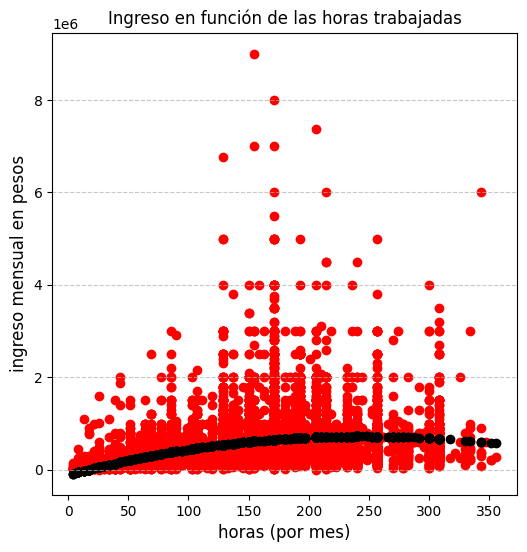

In [ ]:
# grafico
plt.figure(figsize=(6,6))
plt.title('Ingreso en función de las horas trabajadas')

plt.xlabel('horas (por mes)', fontsize=12)
plt.ylabel('ingreso mensual en pesos', fontsize=12)

# Agregar cuadrícula horizontal -- alpha transparencia
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.scatter(x, y, color='red')
plt.scatter(x_test[:,1],y_pred, color='black')
plt.show()

In [ ]:
# Calcular métricas de desempeño

# 1-Error absoluto máximo
EAMAX_reg_poly = max_error(y_test, y_pred)
# 2-Error absoluto medio
EAMED_reg_poly = mean_absolute_error(y_test, y_pred)
# 3-Error cuadratico medio (MSE)
MSE_reg_poly = mean_squared_error(y_test, y_pred)
# 4-RMSE (raiz cuadrada del MSE)
RMSE_reg_poly = np.sqrt(mean_squared_error(y_test, y_pred))
# 5-Coeficiente de determinación (R2)
r2_reg_poly = r2_score(y_test, y_pred)

print(f"Error absoluto máximo: {EAMAX_reg_poly}")
print(f"Error absoluto medio: {EAMED_reg_poly}")
print(f"Error cuadratico medio (MSE): {MSE_reg_poly}")
print(f"Raíz cuadrada error cuadrático medio (RMSE): {RMSE_reg_poly}")
print(f"Coeficiente de determinación: {r2_reg_poly}")

Error absoluto máximo: 5292450.998653101
Error absoluto medio: 285280.9811532112
Error cuadratico medio (MSE): 197702232519.29895
Raíz cuadrada error cuadrático medio (RMSE): 444637.1920108561
Coeficiente de determinación: 0.12249607305123522


## 4.5 Modelo de regresión **múltiple**

In [ ]:
# Dimensiones
print(x_reducida.shape)
print(y.shape)

(13825, 10)
(13825, 1)


In [ ]:
# Dividir entre variable a explicar (y) y variables explicativas (x)

x_train, x_test, y_train, y_test = train_test_split(x_reducida, y, test_size=0.2, random_state=42)
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred = lin_reg.predict(x_test)


In [ ]:
# Calcular métricas de desempeño

# 1-Error absoluto máximo
EAMAX_reg_multiple = max_error(y_test, y_pred)
# 2-Error absoluto medio
EAMED_reg_multiple = mean_absolute_error(y_test, y_pred)
# 3-Error cuadratico medio (MSE)
MSE_reg_multiple = mean_squared_error(y_test, y_pred)
# 4-RMSE (raiz cuadrada del MSE)
RMSE_reg_multiple = np.sqrt(mean_squared_error(y_test, y_pred))
# 5-Coeficiente de determinación (R2)
r2_reg_multiple = lin_reg.score(x_test, y_test)

print(f"Error absoluto máximo: {EAMAX_reg_multiple}")
print(f"Error absoluto medio: {EAMED_reg_multiple}")
print(f"Error cuadratico medio (MSE): {MSE_reg_multiple}")
print(f"Raíz cuadrada error cuadrático medio (RMSE): {RMSE_reg_multiple}")
print(f"Coeficiente de determinación: {r2_reg_multiple}")


Error absoluto máximo: 4982249.017151827
Error absoluto medio: 254126.74507623917
Error cuadratico medio (MSE): 159229780655.03256
Raíz cuadrada error cuadrático medio (RMSE): 399036.0643538784
Coeficiente de determinación: 0.2932565503611998


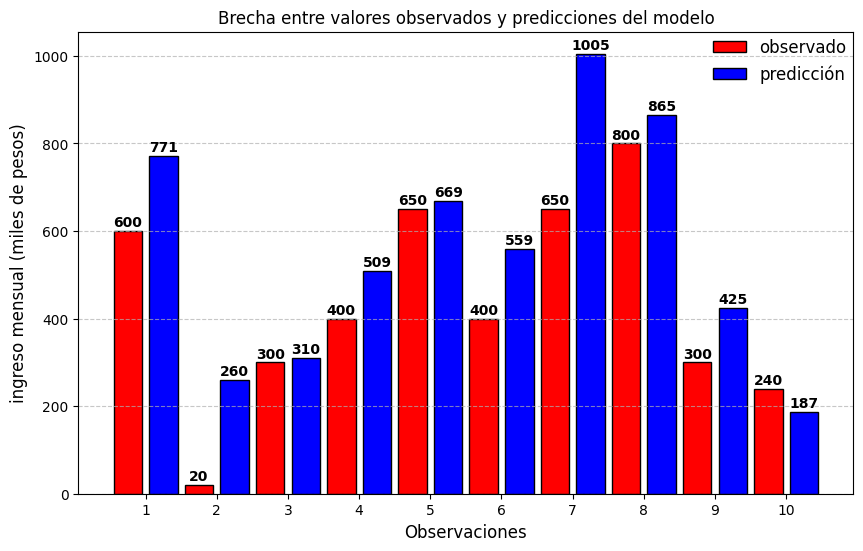

In [ ]:
# Graficar diferencia entre predicciones y valores observados

ancho = 0.25
y_1 = y_test[:10]/1000
y_2 = y_pred[:10]/1000
y_1 = y_1.values.reshape(-1).round(0).astype(int)
y_2 = y_2.reshape(-1).round(0).astype(int)

x_0 = np.arange(len(y_1))
x_1 = x_0 - ancho
x_2 = x_0 + ancho

plt.figure(figsize=(10,6))
plt.bar(x_1, y_1, color='red', edgecolor="black", width=0.4, label='observado')
plt.bar(x_2, y_2, color='blue', edgecolor="black", width=0.4, label='predicción')

plt.title('Brecha entre valores observados y predicciones del modelo')

plt.xlabel('Observaciones', fontsize=12)
plt.xticks(x_0,x_0+1)

plt.ylabel('ingreso mensual (miles de pesos)', fontsize=12)

# Agregar cuadrícula horizontal -- alpha transparencia
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(borderaxespad=0, fontsize=12, frameon=False)

# los valores arriba de la barra i index v value
for i, v in enumerate(y_1):
    plt.text(i-0.25, v+10, str(v), ha="center", fontsize=10, fontweight="bold")
for i, v in enumerate(y_2):
    plt.text(i+0.25, v+10, str(v), ha="center", fontsize=10, fontweight="bold")


Comparando el ingreso que predice el modelo y el ingreso declarado, vemos que el modelo predice valores relativamente cercanos a los declarados en la mayoría de los casos, pero en algunos las diferencias son muy pronunciadas. Por ejemplo, en la observación 2, el modelo predice un ingreso de 260.000 pesos mientras que la encuesta registra un ingreso de 20.000 pesos. Se trata de un valor declarado inusualmente bajo, de manera que podría tratarse de un error de registro. Pero también debemos tener en cuenta que la distribución de los ingresos no es simétrica (esto lo vimos en la primera entrega) ya que hay una gran concentración de valores por debajo de la media cercanos a cero. Eventualmente tal vez se podría mejorar la predicción trabajando con una variable de ingresos en logaritmos, ya que como también mostramos en la primera entrega el logaritmo del ingreso sigue una distribución que se aproxima a la normal.

## 4.6 **Conclusiones**

In [ ]:
print('---------------------------ERROR ABSOLUTO MAXIMO--------------------------------------')
print('Modelo Regresión Simple:', EAMAX_reg_simple)
print('Modelo Regresión Polinómical:',EAMAX_reg_poly)
print('Modelo Regresión Múltiple:',EAMAX_reg_multiple)
print('--------------------------------------------------------------------------------------')
print('-----------------------------ERROR ABSOLUTO MEDIO-------------------------------------')
print('Modelo Regresión Simple:', EAMED_reg_simple)
print('Modelo Regresión Polinómical:',EAMED_reg_poly)
print('Modelo Regresión Múltiple:',EAMED_reg_multiple)
print('--------------------------------------------------------------------------------------')
print('-----------------------------ERROR CUADRATICO MEDIO-----------------------------------')
print('Modelo Regresión Simple:', MSE_reg_simple)
print('Modelo Regresión Polinómical:',MSE_reg_poly)
print('Modelo Regresión Múltiple:',MSE_reg_multiple)
print('--------------------------------------------------------------------------------------')
print('-----------------------RAIZ ERROR CUADRATICO MEDIO------------------------------------')
print('Modelo Regresión Simple:', RMSE_reg_simple)
print('Modelo Regresión Polinómical:',RMSE_reg_poly)
print('Modelo Regresión Múltiple:',RMSE_reg_multiple)
print('--------------------------------------------------------------------------------------')
print('-------------------------COEFICIENTE DE DETERMINACION---------------------------------')
print('Modelo Regresión Simple:', r2_reg_simple)
print('Modelo Regresión Polinómical:',r2_reg_poly)
print('Modelo Regresión Múltiple:',r2_reg_multiple)
print('--------------------------------------------------------------------------------------')


---------------------------ERROR ABSOLUTO MAXIMO--------------------------------------
Modelo Regresión Simple: 5291994.334700597
Modelo Regresión Polinómical: 5292450.998653101
Modelo Regresión Múltiple: 4982249.017151827
--------------------------------------------------------------------------------------
-----------------------------ERROR ABSOLUTO MEDIO-------------------------------------
Modelo Regresión Simple: 292339.98219128937
Modelo Regresión Polinómical: 285280.9811532112
Modelo Regresión Múltiple: 254126.74507623917
--------------------------------------------------------------------------------------
-----------------------------ERROR CUADRATICO MEDIO-----------------------------------
Modelo Regresión Simple: 203720974593.22183
Modelo Regresión Polinómical: 197702232519.29895
Modelo Regresión Múltiple: 159229780655.03256
--------------------------------------------------------------------------------------
-----------------------RAIZ ERROR CUADRATICO MEDIO---------------

Como era de esperar, el modelo de regresión múltiple tiene mejor desempeño que los modelos univariados según cualquier criterio. Los errores (en cualquiera de sus versiones) son siempre menores y el coeficiente de determinación es de 0.293, mayor al de los otros dos modelos (0.096 y 0.122).

El modelo de regresión polinómica tiene mejor ajuste (mayor coeficiente de determinación) que el de regresión simple, y en general los errores son menores, aunque el modelo polinómico tiene un error absoluto máximo ligeramente superior al modelo de regresión simple, si bien la diferencia es insignificante.

Los resultados muestran que es difícil predecir los niveles de ingreso a través de las variables relevadas en encuestas de hogares: el mayor coeficiente de determinación es 0.29. Sin embargo, todavía se pueden introducir mejoras en el modelo que presumiblemente permitirán afinar las predicciones. Por ejemplo, chequear con mayor rigurosidad posibles errores de registro y adoptar un modelo de distribución log-normal para los ingresos que refleja mejor la asimetría observada.

Si tuviéramos que elegir un modelo, evidente sería el de regresión múltiple, que presenta un mejor ajuste y además permite evaluar impacto de cambios en las variables determinantes. De todas maneras, aún con el modelo de mejor desempeño, el error absoluto medio (254.126 pesos) es significativo en relación al ingreso promedio (557.308 pesos), así que los resultados deben tomarse con precaución.

Al realizar la selección de atributos en los modelos de clasificación encontramos que la variable que explica en mayor medida la condición de estar ocupado es la edad. En segundo término el nivel educativo, y en tercer término el sexo. También influye, aunque en menor medida, el hecho de ser jefe de hogar.

La selección de atributos en los modelos de regresión del ingreso de la ocupación principal nos dice que la característica que más contribuye a explicar el nivel de ingresos es la cantidad de horas trabajadas. En segundo lugar la edad, y en tercer lugar el nivel educativo. Las restantes variables tienen una contribución mucho menor. Solo dos actividades económicas fueron seleccionadas entre las 10 principales contribuciones: la actividad económica 0600 (Extracción de petróleo crudo y gas natural) y la 8401 (Servicios de la administración pública y prestación pública de servicios a la comunidad). También influyen características como estar casado y ser jefe de hogar, y estar localizado en alguna de las siguientes regiones: Gran Buenos Aires, Noroeste, Patagonia.